In [1]:
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix

from tqdm import tqdm as track

from dataprep import split_holdout, sample_unseen_interactions
from utils import topk_idx, evaluate
from SGDEigenSim import SGDEigenSim 
from RecWalk.RecWalk import RecWalk  

### Global settings

In [2]:
# randomization control
seed = 0

# to sample unseen items for holdout
holdout_seed = 42 

# evaluation settings
target_metric = 'hr'

# initialize random state
rs = np.random.RandomState(seed)

### Load data -> Yahoo

In [3]:
full_data = pd.read_csv('./data/raw/yahoo_data_full.gz')
full_data.head(5)

,userid,itemid,is_holdout
0,346,1,False
1,385,1,False
2,517,1,False
3,538,1,False
4,651,1,False


### Divide data into train and test

In [4]:
# train test split
train, holdout = split_holdout( 
    full_data,
    sample_max_rated = True,
    feedback = 'is_holdout',
    random_state = rs,
)

# check for problems
assert not train.is_holdout.any()
assert holdout.is_holdout.all()

### Turn train data into CSR format

In [5]:
# encode users and items to [0, N] interval with no missing indices
useridx, all_users = pd.factorize(train.userid)
itemidx, all_items = pd.factorize(train.itemid)

# for efficient storage and some computations
rating_matrix = csr_matrix( 
    (
        np.ones(train.shape[0], dtype='f8'),
        (useridx, itemidx),
    )
)

print(
    "Users: {};\nItems: {};\nNNZ entries: {};\nDensity: {:%}"
    .format(
        *rating_matrix.shape,
        rating_matrix.nnz,
        rating_matrix.nnz / np.prod(rating_matrix.shape)
    )
)

Users: 7307;
Items: 3312;
NNZ entries: 397438;
Density: 1.642253%


### Learn or Load W model

In [6]:
rs = 10
model = SGDEigenSim(rating_matrix, rs)
model.fit(alpha=0.9,
          batch_size=10,
          error=1e-4,
          num_iter=20,
          show_step=(True, 5))

Begin calculations:

Iteration: 5, Error: 0.0050698384749079065, Time for 5 steps: 182.00896573066711


Iteration: 10, Error: 0.005069625440880059, Time for 5 steps: 187.5604841709137


Iteration: 15, Error: 0.005068752556862748, Time for 5 steps: 187.55338048934937


Iteration: 20, Error: 0.005068114354401509, Time for 5 steps: 188.68026542663574


Ended with iterations

Got error = 0.005068114354401509;



In [7]:
model.fit(alpha=0.9,
          batch_size=5,
          error=1e-4,
          num_iter=30,
          show_step=(True, 5))

Begin calculations:

Iteration: 5, Error: 0.005067691880700982, Time for 5 steps: 83.42635440826416


Iteration: 10, Error: 0.005067255069747381, Time for 5 steps: 83.49697422981262


Iteration: 15, Error: 0.005067134623597058, Time for 5 steps: 81.67678785324097


Iteration: 20, Error: 0.005066973677899771, Time for 5 steps: 83.38777685165405


Iteration: 25, Error: 0.005066593802935189, Time for 5 steps: 83.408926486969


Iteration: 30, Error: 0.005066514197211047, Time for 5 steps: 84.71939206123352


Ended with iterations

Got error = 0.005066514197211047;



In [8]:
model.fit(alpha=0.9,
          batch_size=20,
          error=1e-4,
          num_iter=10,
          show_step=(True, 5))

Begin calculations:

Iteration: 5, Error: 0.005066079372847488, Time for 5 steps: 607.5131783485413


Iteration: 10, Error: 0.005065823931222169, Time for 5 steps: 607.2258846759796


Ended with iterations

Got error = 0.005065823931222169;



In [9]:
W = csr_matrix(model.get_model())

#Density of distance matrix W, diagonal and other elements
print(f"Density of W: {W.nnz / np.prod(W.shape):%}")
print(f"Number of elements less than 0 in W: {(W.data<0).sum()}")
print(f"Maximal diagonal element of the W:   {W.diagonal().max()}")
print(f"Minimal diagonal element of the W:   {W.diagonal().min()}")

Density of W: 100.000000%
Number of elements less than 0 in W: 5490246
Maximal diagonal element of the W:   0.6975513777117384
Minimal diagonal element of the W:   0.2915987101704293


### Define RecWalk Model

In [10]:
# RecWalk P matrix with W model:
transition_matrix = RecWalk(W, rating_matrix).get_model()
print(f"Density of P:\
      {transition_matrix.nnz / np.prod(transition_matrix.shape) :%}")

Density of P:      10.439160%


### Prepare for evaluation step

In [11]:
# sample 999 random unseen items per user
holdout_unseen = sample_unseen_interactions(
    full_data,
    train.itemid.unique(), 
    seed=holdout_seed,
)

# put holdout_unseen into 2 dim ndarray and sub 1 from everyone
unseen_samples = np.array([
    [all_items.get_loc(i) for i in x]
    for x in holdout_unseen.loc[all_users]
])

# put holdout into ndarray and sub 1 from everyone
holdout_items = (
    holdout
    .set_index('userid')
    .loc[all_users, 'itemid']
    .map(all_items.get_loc)
    .values
)

### Evaluation

In [12]:
# Make a few more steps to future to capture intersactions between items:
K = 20

n_users = rating_matrix.shape[0]
k_step_matrix = transition_matrix[:n_users, :].toarray()
transition_matrix = transition_matrix.tocsc()

metrics = []
for k in track(range(K)): 
    k_step_matrix = transition_matrix.T.dot(k_step_matrix.T).T
    prediction_matrix = k_step_matrix[:, n_users:]
    metrics.append(
        evaluate(prediction_matrix, holdout_items, unseen_samples)
    )

100%|██████████| 20/20 [28:59<00:00, 86.98s/it]


### Get graphical results

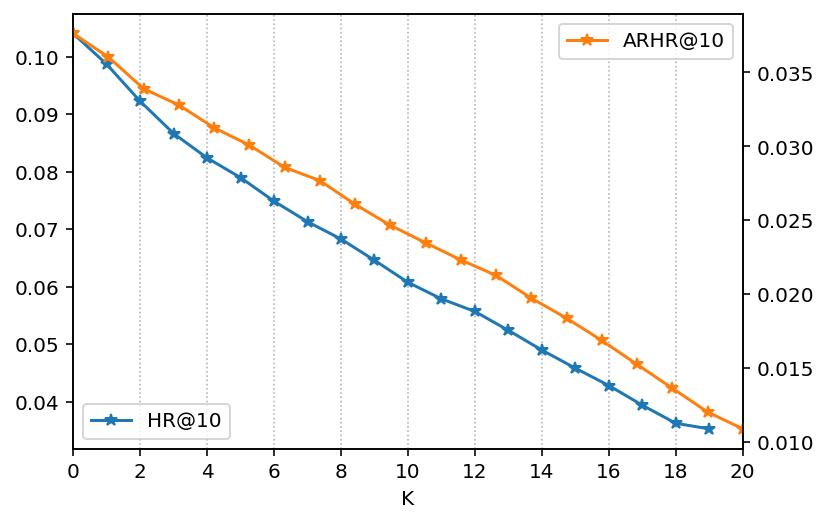

In [13]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

hr, arhr = zip(*metrics)

ax1 = pd.Series(hr).plot(linestyle='-', marker='*', label='HR@10')
ax2 = pd.Series(arhr).plot(secondary_y=True, linestyle='-', marker='*', label='ARHR@10')

ax1.set_xlabel('K')
ax1.xaxis.grid(True, linestyle=':')
ax1.set_xticks(range(0, 22, 2))
ax1.legend(loc=3)

ax2.legend(loc=0);

### Some statistics on eigenvalues

In [21]:
print(f"max = {model.get_eigenvalues().max()}\n")
print(f"min = {model.get_eigenvalues().min()}\n")
print(f"mean = {model.get_eigenvalues().mean()}\n")
print(f"std = {model.get_eigenvalues().std()}\n")

max = 1.0001343173759485

min = 0.00028338880383233623

mean = 0.4885226104907697

std = 0.2904311597212879

